自己一直很感兴趣的影像数据，想试一下

In [ ]:
!wget http://bioinfo.konkuk.ac.kr/DLEB/data/example_image.tar.gz

In [3]:
pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!tar -zxvf /content/image/example_image.tar.gz

In [4]:
import numpy as np
from PIL import Image
img = Image.open("/content/example_image/example_images.toy_data/insitu10005.jpg")
imgArray = np.array(img)
print(imgArray.shape)

(128, 320, 3)


In [30]:
match = {'stage1-3': 1, 'stage4-6': 2, 'stage7-8': 3, 'stage9-10': 4, 'stage11-12': 5, 'stage13-16': 6}

In [34]:
seq_Mat_v = match['stage4-6']
print(seq_Mat_v)

2


In [47]:
data_file=('/content/example_image/image_stage.label.txt')

label_list, feature_list= [], []

with open(data_file) as f:
  for line in f.readlines()[1:10]:
    file,label = line.strip().split('\t')
    matv = match[label]
    img = Image.open("/content/example_image/example_images.all_data/"+file)
    feature = np.array(img)
    label_list.append(matv)
    feature_list.append(feature)

In [ ]:
print(label_list[1],feature_list[1])

先做一个简单的CNN试试

In [49]:
X_label = np.array(label_list)
X_feature = np.array(feature_list)

报错，应该对于label需要有什么转换？

In [50]:
from keras.utils import to_categorical
X_label = to_categorical(X_label,6)

In [51]:
import keras
from keras.layers import *
from keras.models import *
from tensorflow.keras import optimizers
import tensorflow as tf


from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_feature, X_label, test_size = 0.75, random_state = 0)

In [ ]:
model = Sequential()
model.add(Input(shape=(128,320,3)))
model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu')) 
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2))) 
model.add(Flatten())                                                              
model.add(Dense(50, activation='relu')) 
model.add(Dropout(0.2))  
model.add(Dense(25, activation='relu'))                                               
model.add(Dense(6, activation='softmax'))              

model.summary()

opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
model.compile(optimizer = opt,                    
       loss = 'categorical_crossentropy',    
       metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=125, epochs=30, validation_split=0.2)

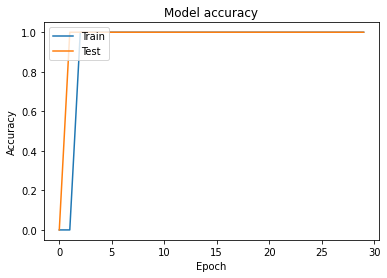

In [56]:
import matplotlib.pyplot as plt
# 绘制训练 & 验证的准确率值
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

ACC直接到1了，猝不及防的